This notebook contains the code to classify genes from bacterias and archeas profiles with CNN trained on matrix representation of said profiles.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
import keras
from keras.models import Sequential
from keras.layers import Conv2D,Dense,Flatten,Dropout
from keras.optimizers import Adam
from keras.callbacks import TensorBoard
import time
from random import shuffle

C:\Users\maely\miniconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\maely\miniconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\maely\miniconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
# data path
database_path='./profiles/'
archea_full_genome_files = '-mer_all_archea_profiles.csv'
bacteria_full_genome_files = '-mer_all_bacteria_profiles.csv'
archea_genes_files = '-mer_archea_genes.csv'
bacteria_genes_files = '-mer_bacteria_genes.csv'

In [3]:
# parameters
k_values = [3, 5]

In [4]:
# functions
# 2. Converting profiles to matrix representation and normalization
def kmer2str(val, k):
    """ Transform a kmer integer into a its string representation"""
    letters = ['A', 'C', 'T', 'G']
    str_val = []
    for i in range(k):
        str_val.append(letters[val & 0b11])
        val >>= 2

    str_val.reverse()
    return "".join(str_val)
            
def matrix(data, k, columns):
    """From a kmer profile, computes a matrix representation"""
    size = int(np.sqrt(4**k))
    mat = np.zeros((size, size))
    for i in range(len(data)):
        x_max = size-1
        x_min = 0
        y_max = size-1
        y_min = 0
        kmer = kmer2str(int(columns[i]), k)
        for j in range(1,(k+1)):
            if kmer[-j]=="C":
                x_max =x_min + np.floor((x_max-x_min)/2)
                y_max =y_min + np.floor((y_max-y_min)/2)
            if kmer[-j]=="A":
                x_max = x_min + np.floor((x_max-x_min)/2)
                y_min = y_min + np.floor((y_max-y_min)/2)
            if kmer[-j]=="G":
                y_max = y_min + np.floor((y_max-y_min)/2)
                x_min = x_min + np.floor((x_max-x_min)/2)
            if kmer[-j]=="T":
                y_min =y_min + np.floor((y_max-y_min)/2)
                x_min = x_min + np.floor((x_max-x_min)/2)
        mat[int(y_max),int(x_max)] = data[i]
    
    return np.array(mat)

def from_profile_to_matrix(dataset, k):
    """Converts a k-mer profile dataset to a matrix dataset"""
    res_data = []
    columns = list(dataset.columns)
    size = int(np.sqrt(4**k))
    for index, line in dataset.iterrows():
        res_data += [preprocessing.normalize(matrix(line, k, columns)).reshape(size*size,)]
    return pd.DataFrame(np.array(res_data), index = dataset.index)

In [5]:
# 1. loading data, converting to matrix and combining archea/bacteria files
genome_dataset={}
genes_dataset={}
for k in k_values:
    print(f'Loading data for {k}-mers:')
    
    archea_file = database_path + str(k) + archea_genes_files
    bacteria_file = database_path + str(k) + bacteria_genes_files
    print(archea_file)
    archea_genes = pd.read_csv(archea_file, sep='\t', index_col=0)
    archea_genes = from_profile_to_matrix(archea_genes.fillna(0), k)
    
    print(bacteria_file)
    bacteria_genes = pd.read_csv(bacteria_file, sep='\t', index_col=0)
    bacteria_genes = from_profile_to_matrix(bacteria_genes.fillna(0), k)
    
    genes_data = pd.concat([archea_genes, bacteria_genes])
    genes_dataset[k] = genes_data
    
    archea_file = database_path + str(k) + archea_full_genome_files
    bacteria_file = database_path + str(k) + bacteria_full_genome_files
    print(archea_file)
    archea_genome = pd.read_csv(archea_file, sep='\t', index_col=0)
    archea_genome = from_profile_to_matrix(archea_genome.fillna(0), k)
    
    print(bacteria_file)
    bacteria_genome = pd.read_csv(bacteria_file, sep='\t', index_col=0)
    bacteria_genome = from_profile_to_matrix(bacteria_genome.fillna(0), k)
    
    genome_data = pd.concat([archea_genome, bacteria_genome])
    genome_dataset[k] = genome_data

Loading data for 3-mers:
./profiles/3-mer_archea_genes.csv
./profiles/3-mer_bacteria_genes.csv
./profiles/3-mer_all_archea_profiles.csv
./profiles/3-mer_all_bacteria_profiles.csv
Loading data for 5-mers:
./profiles/5-mer_archea_genes.csv
./profiles/5-mer_bacteria_genes.csv
./profiles/5-mer_all_archea_profiles.csv
./profiles/5-mer_all_bacteria_profiles.csv


Datasets for 3-mers


,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
Aeropyrum_pernix_K1,0.614261,0.620315,0.320271,0.0,0.367859,0.0,0.0,0.0,0.339184,0.415514,...,0.0,0.0,0.377789,0.475346,0.734753,0.0,0.302422,0.0,0.0,0.0
Archaeoglobus_fulgidus_DSM_4304,0.570508,0.575265,0.369748,0.0,0.454838,0.0,0.0,0.0,0.304287,0.464648,...,0.0,0.0,0.730674,0.369255,0.311901,0.0,0.482166,0.0,0.0,0.0
Archaeoglobus_profundus_DSM_5631,0.585721,0.534089,0.362182,0.0,0.490412,0.0,0.0,0.0,0.329633,0.484914,...,0.0,0.0,0.639226,0.452973,0.413332,0.0,0.464070,0.0,0.0,0.0
Caldivirga_maquilingensis_IC_167,0.701256,0.617350,0.239727,0.0,0.263913,0.0,0.0,0.0,0.523103,0.346530,...,0.0,0.0,0.227447,0.705316,0.421534,0.0,0.522595,0.0,0.0,0.0
Candidatus_Korarchaeum_cryptofilum_OPF8,0.764613,0.460347,0.271453,0.0,0.360224,0.0,0.0,0.0,0.232802,0.575756,...,0.0,0.0,0.362836,0.439404,0.686287,0.0,0.451978,0.0,0.0,0.0


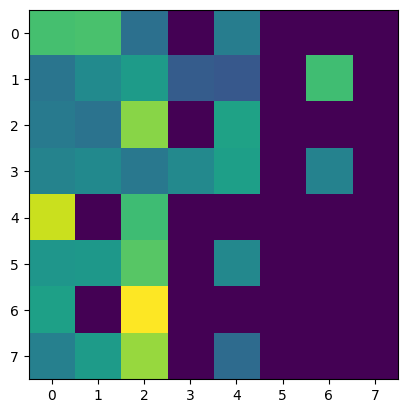

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
Aeropyrum_pernix_K1.1027,0.160128,0.800641,0.320256,0.0,0.480384,0.0,0.0,0.0,0.253510,0.354914,...,0.0,0.0,0.508001,0.423334,0.719667,0.0,0.211667,0.0,0.0,0.0
Aeropyrum_pernix_K1.102,0.505346,0.703875,0.324865,0.0,0.379010,0.0,0.0,0.0,0.267493,0.346167,...,0.0,0.0,0.488716,0.402472,0.718699,0.0,0.287480,0.0,0.0,0.0
Aeropyrum_pernix_K1.1089,0.614319,0.544111,0.421247,0.0,0.386143,0.0,0.0,0.0,0.316166,0.434728,...,0.0,0.0,0.249513,0.561405,0.748539,0.0,0.249513,0.0,0.0,0.0
Aeropyrum_pernix_K1.1119,0.457164,0.761939,0.304776,0.0,0.342873,0.0,0.0,0.0,0.222394,0.333591,...,0.0,0.0,0.340503,0.595880,0.681005,0.0,0.255377,0.0,0.0,0.0
Aeropyrum_pernix_K1.1157,0.701934,0.539949,0.269975,0.0,0.377964,0.0,0.0,0.0,0.406558,0.386230,...,0.0,0.0,0.251478,0.628695,0.691564,0.0,0.251478,0.0,0.0,0.0


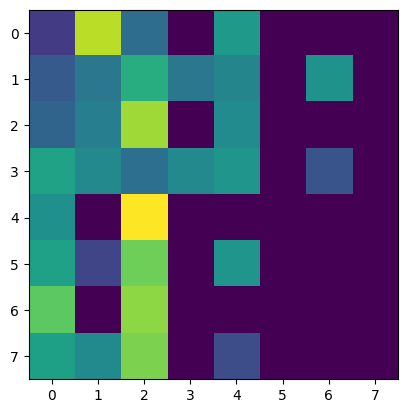

Datasets for 5-mers


,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
Aeropyrum_pernix_K1,0.379935,0.312117,0.245980,0.272779,0.323061,0.156576,0.240508,0.0,0.215388,0.276269,...,0.0,0.0,0.080388,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Archaeoglobus_fulgidus_DSM_4304,0.327442,0.333309,0.283790,0.188729,0.355981,0.107689,0.236459,0.0,0.304174,0.223035,...,0.0,0.0,0.330455,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Archaeoglobus_profundus_DSM_5631,0.298401,0.272677,0.241441,0.184480,0.321553,0.134869,0.207264,0.0,0.308691,0.135236,...,0.0,0.0,0.314763,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Caldivirga_maquilingensis_IC_167,0.462672,0.426564,0.166910,0.364385,0.239427,0.238978,0.190733,0.0,0.134547,0.312693,...,0.0,0.0,0.086581,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Candidatus_Korarchaeum_cryptofilum_OPF8,0.490538,0.397628,0.177482,0.388857,0.149327,0.091069,0.184087,0.0,0.207369,0.149977,...,0.0,0.0,0.220948,0.0,0.0,0.0,0.0,0.0,0.0,0.0


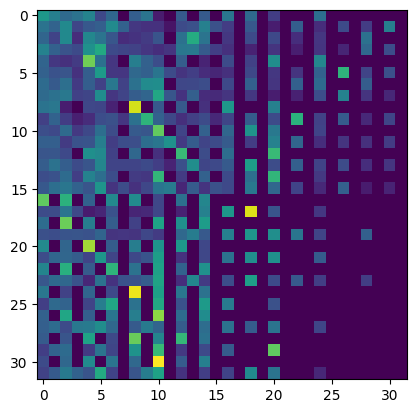

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
Aeropyrum_pernix_K1.1000,0.065512,0.196537,0.131024,0.196537,0.458585,0.065512,0.524097,0.0,0.065512,0.458585,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Aeropyrum_pernix_K1.1013,0.435788,0.272367,0.163420,0.272367,0.217894,0.272367,0.108947,0.0,0.054473,0.326841,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Aeropyrum_pernix_K1.1014,0.442401,0.165900,0.165900,0.000000,0.055300,0.442401,0.055300,0.0,0.221201,0.331801,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Aeropyrum_pernix_K1.1017,0.222222,0.333333,0.333333,0.333333,0.111111,0.222222,0.444444,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Aeropyrum_pernix_K1.102,0.000000,0.344124,0.229416,0.458831,0.229416,0.229416,0.573539,0.0,0.114708,0.114708,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


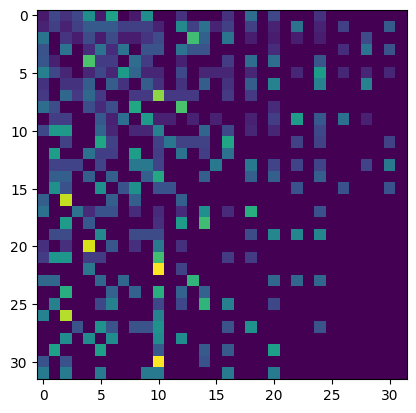

In [6]:
for k in k_values:
    size = int(np.sqrt(4**k))
    if k in genome_dataset:
        print(f'Datasets for {k}-mers')
        display(genome_dataset[k].head())
        plt.imshow(np.array(genome_dataset[k].iloc[0]).reshape((size,size)))
        plt.show()
        display(genes_dataset[k].head())    
        plt.imshow(np.array(genes_dataset[k].iloc[0]).reshape((size,size)))
        plt.show()

In [7]:
# 2. Preprocessing data for convolution
X_genes = {}
y_genes = {}
X_genome = {}
y_genome = {}
image_shapes = {}
y_values = list(np.unique(genome_dataset[k_values[0]].index))

for k in k_values:
    size = int(np.sqrt(4**k))
    image_rows = size
    image_cols = size
    image_shapes[k] = (image_rows,image_cols,1) 
    
    # loading the genome dataset
    genome = genome_dataset[k]
    X_genome[k] = np.array(genome)
    y_genome[k] = np.array([y_values.index(val) for val in list(genome.index)])
        
    # we shuffle the genes dataset in order to separate the species genes and randomize cross validation
    genes = genes_dataset[k]
    ind_list = [i for i in range(len(genes))]
    shuffle(ind_list)
    genes = genes.loc[np.array(genes.index)[ind_list]]
    X_genes[k] = np.array(genes)
    y_genes[k] = np.array([y_values.index(species.split('.')[0]) for species in genes.index])
    
    # we reshape the datasets to get a matrix shape for the convolution
    X_genes[k] = X_genes[k].reshape(X_genes[k].shape[0],*image_shapes[k])
    X_genome[k] = X_genome[k].reshape(X_genome[k].shape[0],*image_shapes[k])
    

In [8]:
# 3. Constructing simple CNN models (one convolutional layer proved to be the most efficient)
cnn_model = {}
for k in k_values:
    cnn_model[k] = Sequential([
        Conv2D(filters=100, kernel_size=3,activation='relu', input_shape = image_shapes[k]),
        Dropout(0.05), # randomly puts 0 in weights in order to avoid overfitting
        Flatten(), # puts the dataset in one dimension (classical procedure between convolution and other layers)
        Dense(len(y_values),activation = 'softmax') # Dense layer to get classification
    ])
    cnn_model[k].compile(loss ='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001),metrics =['accuracy'])

In [9]:
# 4. Computing scores and time in cross validation (genes training)
def split_for_cross_val(X, y, splits):
    """Splits dataset for cross validation"""
    len_dataset = len(X)
    split_size = int(len_dataset/splits)
    X_subset = []
    y_subset = []
    for i in range(splits):
        split = [ind for ind in range(split_size*i, split_size * (i+1)) if ind < len_dataset]
        other = [ind for ind in range(len_dataset) if ind not in split]
        X_subset += [(X[split], X[other])]
        y_subset += [(y[split], y[other])]
    return X_subset, y_subset
        
s = 5
results_table = np.zeros((2, len(k_values)))
for k in k_values:
    print(f'Computing {k}-mer...')
    X_subset, y_subset = split_for_cross_val(X_genes[k], y_genes[k], s)
    scores = []
    times = []
    for i in range(s):
        X_test, X_train = X_subset[i]
        y_test, y_train = y_subset[i]
        time_start = time.time()
        history = cnn_model[k].fit(
        X_train,
        y_train,
        batch_size=len(y_train),
        epochs=100,
        verbose=False
        )
        time_end = time.time()
        scores += [cnn_model[k].evaluate(X_test,y_test,verbose=0)[1]]
        times += [time_end - time_start]
    results_table[0, k_values.index(k)] = np.mean(scores)
    results_table[1, k_values.index(k)] = np.mean(times)
    print('Score:', np.mean(scores),'\tTime:', np.mean(times))

Computing 3-mer...


Score: 0.628292691707611 	Time: 17.2403386592865
Computing 5-mer...
Score: 0.9349397540092468 	Time: 569.101879310608


Training for 3-mers


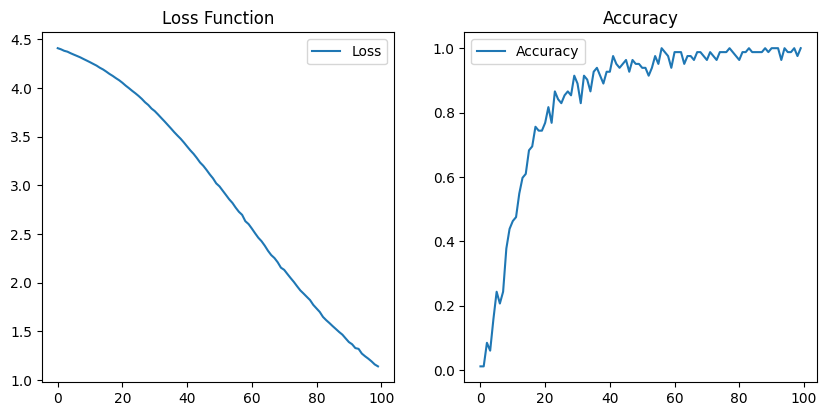

Training for 5-mers


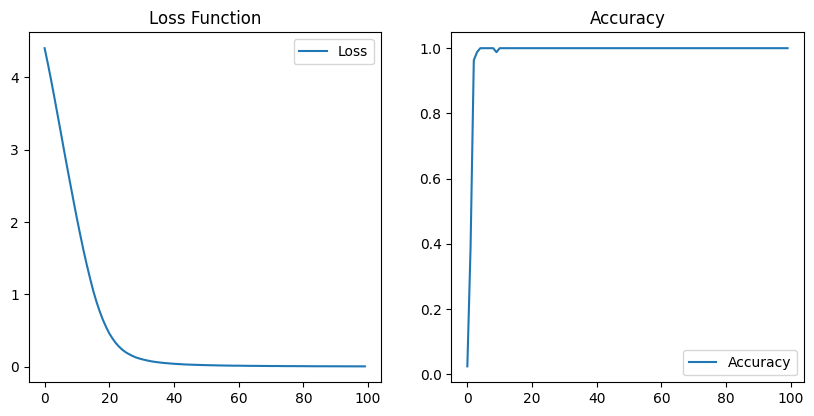

In [10]:
# 5. As reference computing scores with genome training (due to the fact that genes are a different dataset, we cannot cross-validate)
results_table_genome = np.zeros((2, len(k_values)))
for k in k_values:
    batch_size = len(X_genome[k])
    time_start = time.time()
    cnn = Sequential([
        Conv2D(filters=100, kernel_size=3,activation='relu', input_shape = image_shapes[k]),
        Dropout(0.05), # randomly puts 0 in weights in order to avoid overfitting
        Flatten(), # puts the dataset in one dimension (classical procedure between convolution and other layers)
        Dense(len(y_values),activation = 'softmax') # Dense layer to get classification
    ])
    cnn.compile(loss ='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001),metrics =['accuracy'])
    history = cnn.fit(
        X_genome[k],
        y_genome[k],
        batch_size=batch_size,
        epochs=100,
        verbose=False
    )
    results_table_genome[0, k_values.index(k)] = cnn_model[k].evaluate(X_genes[k],y_genes[k],verbose=0)[1]
    time_end = time.time()
    results_table_genome[1, k_values.index(k)] = time_end - time_start
    print(f'Training for {k}-mers')
    plt.figure(figsize=(10, 10))
    plt.subplot(2, 2, 1)
    plt.plot(history.history['loss'], label='Loss')
    plt.legend()
    plt.title('Loss Function')
    plt.subplot(2, 2, 2)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.legend()
    plt.title('Accuracy')
    plt.show()

In [13]:
# 6. Writting result files
import os
if not os.path.exists('CNN_results'):
    os.mkdir('CNN_results')
results = pd.DataFrame([
    results_table[0],
    results_table_genome[0]
], index = ['Genes training(cross-val)', 'Genome training'],
columns = k_values)
results.to_csv('CNN_results/accuracies_per_fold.csv')
times = pd.DataFrame([
    results_table[1],
    results_table_genome[1]
], index = ['Genes training(cross-val)', 'Genome training'],
columns = k_values)
times.to_csv('CNN_results/execution_times.csv')